In [ ]:
"""
1. Multiple logistic regression model
Using all continuous features
(city_development_index, experience, last_new_job, training_hours)
    - roc_auc_score = 0.683
    - explore threshold values (0.139 for high recall)
    - examin F1 score, log loss
    
2. KNN model
3. Naive Bayes model

Note: accuracy_score is not meaningful due to imbalanced classes

"""

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


import importlib
import sys
sys.path.append('/Users/katiehuang/Desktop/metis/projects/onl_ds5_project_3/py')
from logistic import *

In [2]:
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')

In [68]:
df_train.shape

(19158, 14)

In [3]:
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['target']

### 1. Logistic Regression

In [4]:
lm = LogisticRegression()
lm.fit(X_train, y_train)
X_test = scaler.transform(df_test[features])
y_test = df_test['target']
preds = lm.predict(X_test)

In [5]:
# Threshold = 0.5
pd.DataFrame(confusion_matrix(df_test['target'], preds),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1445,108
Changing (1),386,190


In [6]:
roc_auc_score(y_test,preds)

0.6301591453816986

In [7]:
# Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lm,X_test, y_test, cv=5, scoring='roc_auc')
print('Scores:', cv_scores)
print('Mean:', np.mean(cv_scores))

Scores: [0.74089266 0.7017615  0.69201734 0.69766532 0.69147265]
Mean: 0.7047618917177652


#### Explore threshold values

In [108]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [109]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [12]:
df_test['proba_change'] = lm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['target'],
                                 df_test['proba_change'])

In [14]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

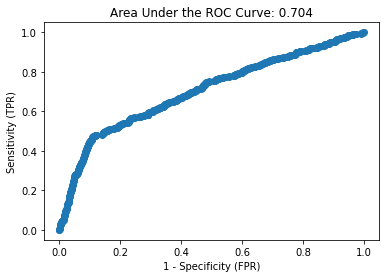

In [19]:
plot_roc(df_test['target'], lm.predict_proba(X_test)[:, 1])

In [20]:
mask = tpr > 0.95
thresholds[mask].max()

0.1134861071669832

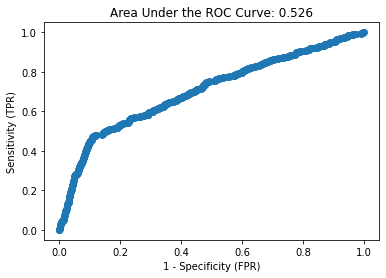

In [21]:
plot_roc(df_test['target'], lm.predict_proba(X_test)[:, 1] >= 0.113)

In [22]:
preds_low_th = (lm.predict_proba(X_test)[:, 1] >= 0.113)

# Threshold = 0.146
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),155,1398
Changing (1),28,548


In [37]:
print(classification_report(df_test['target'],np.array(preds_low_th)))

              precision    recall  f1-score   support

           0       0.85      0.10      0.18      1553
           1       0.28      0.95      0.43       576

    accuracy                           0.33      2129
   macro avg       0.56      0.53      0.31      2129
weighted avg       0.69      0.33      0.25      2129



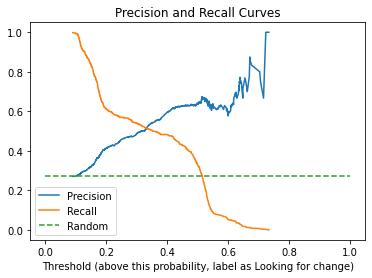

In [25]:
# Precision, recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1])
plt.plot(thresholds, precision[1:],label='Precision')
plt.plot(thresholds, recall[1:],label='Recall');

# Plot random guess precision, recall currve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')

plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Looking for change)');
plt.title('Precision and Recall Curves');

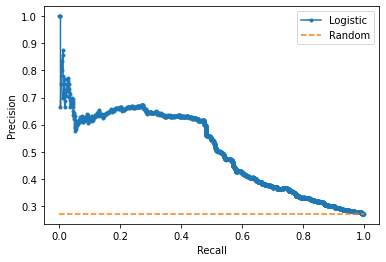

In [26]:
plt.plot(recall, precision, marker='.', label='Logistic')

# Plot random guess precision, recall currve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [31]:
# ROC AUC score
score_default = roc_auc_score(y_test, lm.predict(X_test)) # Threshold = 0.5
score_low_th = roc_auc_score(y_test, lm.predict_proba(X_test)[:, 1] > 0.113) # Threshold = 0.113
print('ROC AUC score (threshold = 0.5):', score_default)
print('ROC AUC score (threshold = 0.113):', score_low_th)

ROC AUC score (threshold = 0.5): 0.6301591453816986
ROC AUC score (threshold = 0.113): 0.5255978571939615


In [34]:
# F1 score
score_default = f1_score(y_test, lm.predict(X_test)) # Threshold = 0.5
score_low_th = f1_score(y_test, lm.predict_proba(X_test)[:, 1] > 0.113) # Threshold = 0.113
print('F1 score (threshold = 0.5):', score_default)
print('F1 score (threshold = 0.113):', score_low_th)

F1 score (threshold = 0.5): 0.4347826086956522
F1 score (threshold = 0.113): 0.43457573354480566


In [35]:
# Log loss score
score_default = log_loss(y_test, lm.predict(X_test)) # Threshold = 0.5
score_low_th = log_loss(y_test, lm.predict_proba(X_test)[:, 1] > 0.113) # Threshold = 0.113
print('Log loss (threshold = 0.5):', score_default)
print('Log loss (threshold = 0.113):', score_low_th)

Log loss (threshold = 0.5): 8.014204741948493
Log loss (threshold = 0.113): 23.13452934539692


### 2. KNN

In [39]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report:\n\n',classification_report(y_test,pred))

Accuracy score: 0.7195866604039455 

Classification report:

               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1553
           1       0.47      0.34      0.40       576

    accuracy                           0.72      2129
   macro avg       0.63      0.60      0.61      2129
weighted avg       0.70      0.72      0.70      2129



In [67]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
pred = knn_5.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report:\n\n',classification_report(y_test,pred))

Accuracy score: 0.7397839361202443 

Classification report:

               precision    recall  f1-score   support

           0       0.78      0.89      0.83      1553
           1       0.53      0.34      0.41       576

    accuracy                           0.74      2129
   macro avg       0.66      0.61      0.62      2129
weighted avg       0.71      0.74      0.72      2129



In [105]:
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train,y_train)
pred = knn_7.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7477689055894786 

Classification report (kNN):

               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1553
           1       0.56      0.34      0.42       576

    accuracy                           0.75      2129
   macro avg       0.67      0.62      0.63      2129
weighted avg       0.72      0.75      0.73      2129



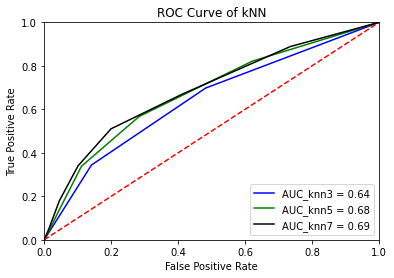

In [96]:
# knn (n=3)
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_knn3 = %0.2f' % roc_auc)

# knn (n=5)
y_scores = knn_5.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC_knn5 = %0.2f' % roc_auc)

# knn (n=7)
y_scores = knn_7.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k', label = 'AUC_knn7 = %0.2f' % roc_auc)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### 3. Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)

In [104]:
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7660873649600751 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1553
           1       0.59      0.46      0.52       576

    accuracy                           0.77      2129
   macro avg       0.70      0.67      0.68      2129
weighted avg       0.75      0.77      0.76      2129



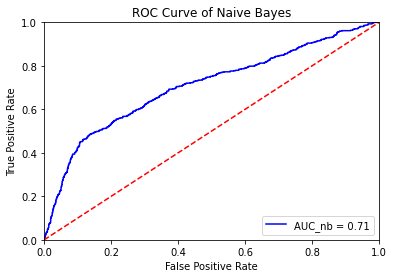

In [107]:
# Naive Bayes
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()